In [2]:
library(Seurat)
library(Matrix)
library(stringr)
library(ggplot2)
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(topGO)
library(plyr)
library(igraph)
library(networkD3)
library(ggrepel)
library(magrittr)
library(dplyr)
library(EnsDb.Hsapiens.v79)
library(mygene)
library(org.Hs.eg.db)
library(GeneBook)
library(UniProt.ws)
library(robustbase)
library(PerformanceAnalytics)
library(factoextra)
library(EnsDb.Hsapiens.v79)
library(mygene)
library(org.Hs.eg.db)
library(GeneBook)
library(UniProt.ws)
library(ggpubr)
library(gridExtra)
library(cowplot)

In [3]:
font_size <- 12
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [4]:
load(file = "sample_info_for_Ex.Rdata")

In [6]:
sample_info_for_Ex$scaler <- sample_info_for_Ex$read4Ex/(mean(sample_info_for_Ex$read4Ex))

In [7]:
bulkbrain_variant_ann <- fread("Ex76_selectedVCF_dropGT_ALLchr_GENE.tsv",
                          header = TRUE, sep = "\t", fill = TRUE) %>% as.data.frame()
colnames(bulkbrain_variant_ann) <- c("CHROM", "POS", "REF", "ALT", "ANN.EFFECT", "ANN.GENE")

In [9]:
bulkbrain_variant_ann$EFFECT <- sapply(bulkbrain_variant_ann$ANN.EFFECT, function(x){
    return(unlist(str_split(x, ","))[1])
})
bulkbrain_variant_ann$GENE <- sapply(bulkbrain_variant_ann$ANN.GENE, function(x){
    return(unlist(str_split(x, ","))[1])
})

In [10]:
bulkbrain_variant_ann$ID <- apply(bulkbrain_variant_ann, 1, function(x){
    return(gsub(" ", "", paste(x[1], x[2], sep=':')))
}) 

In [11]:
load(file="Ex76_read_count_matrixs_gD10_addWGS.Rdata")

In [13]:
bulkbrain_variant_ann <- bulkbrain_variant_ann[which(bulkbrain_variant_ann$ID %in% as.character(read_count_matrixs[[1]]$POS)), ]

In [16]:
count_read <- NULL

In [17]:
for(i in 1:length(read_count_matrixs)){
    count_read <- cbind(count_read, read_count_matrixs[[i]]$sum)
}

In [18]:
min_read = 25
ratio = 0.1

cutoff <- NULL
for(id in 1:nrow(sample_info_for_Ex)){
    cutoff <- cbind(cutoff, rep(sample_info_for_Ex[id, ]$scaler * min_read, nrow(count_read)))
}

cout_gD_matrix <- data.frame(count = rowSums(count_read >= cutoff))

cout_gD_matrix$ratio <- cout_gD_matrix$count / ncol(count_read)
cout_gD_matrix$keep <- cout_gD_matrix$ratio == 1

print(sum(cout_gD_matrix$keep))

[1] 9991


In [20]:
for(i in 1:length(read_count_matrixs)){
    read_count_matrixs[[i]]$has_mutation <- 0
    
    ref2alt_idx <- which((read_count_matrixs[[i]]$WGS == 1) & (cout_gD_matrix$keep) & 
      ((read_count_matrixs[[i]]$alt / (read_count_matrixs[[i]]$alt + 
                                            read_count_matrixs[[i]]$ref)) >= ratio) )
    
    alt2ref_idx <- which((read_count_matrixs[[i]]$WGS == 2) & (cout_gD_matrix$keep) & 
      ((read_count_matrixs[[i]]$ref / (read_count_matrixs[[i]]$alt + 
                                            read_count_matrixs[[i]]$ref)) >= ratio) )
    
    if(length(c(ref2alt_idx, alt2ref_idx)) != 0){
        read_count_matrixs[[i]][c(ref2alt_idx, alt2ref_idx), ]$has_mutation <- 1
    }
}

In [21]:
gene_sample_mutation <- NULL
for(i in 1:length(read_count_matrixs)){
    gene_sample_mutation <- cbind(gene_sample_mutation, read_count_matrixs[[i]]$has_mutation)
}

In [22]:
rownames(gene_sample_mutation) <- read_count_matrixs[[1]]$POS
colnames(gene_sample_mutation) <- names(read_count_matrixs)

In [23]:
gene_mutation_sum <- rowSums(gene_sample_mutation)

In [24]:
sum(gene_mutation_sum != 0)

[1] 196

In [25]:
mutated_gene_sample <- cbind(bulkbrain_variant_ann[which(gene_mutation_sum != 0), ],
                             gene_sample_mutation[which(gene_mutation_sum != 0), ])

In [26]:
mutated_gene_sample$sum <- gene_mutation_sum[which(gene_mutation_sum != 0)]

In [27]:
POS_sample_mutation <- gene_sample_mutation[which(gene_mutation_sum != 0), ]

In [28]:
mutation_count_persample <- data.frame(ID = colnames(POS_sample_mutation), count = colSums(POS_sample_mutation), 
                                       stringsAsFactors = FALSE)

In [29]:
sample_info_for_Ex$count <- sapply(sample_info_for_Ex$individualID, function(x){
    return(mutation_count_persample[which(mutation_count_persample$ID ==x), ]$count)
})

In [30]:
sample_info_for_Ex$group <- ""
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(1, 2, 3)), ]$group <- "ND"
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(4, 5)), ]$group <- "AD"
sample_info_for_Ex[which(sample_info_for_Ex$cogdx %in% c(6)), ]$group <- "Other"

In [31]:
sample_info_for_Ex$ADND <- NA
sample_info_for_Ex[sample_info_for_Ex$cogdx == 1, ]$ADND  <- "ND"
sample_info_for_Ex[sample_info_for_Ex$cogdx == 4, ]$ADND  <- "AD"

In [33]:
sample_info_for_Ex$isAD <- "no"
sample_info_for_Ex[sample_info_for_Ex$cogdx %in% c(4, 5), ]$isAD  <- "yes"

In [34]:
table(subset(sample_info_for_Ex, group == "ND")$sex)
summary(subset(sample_info_for_Ex, group == "ND")$age)
sd(subset(sample_info_for_Ex, group == "ND")$age)


 0  1 
23 19 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  76.00   83.25   86.50   85.74   90.00   90.00 

[1] 4.202552

In [35]:
table(subset(sample_info_for_Ex, group == "AD")$sex)
summary(subset(sample_info_for_Ex, group == "AD")$age)
sd(subset(sample_info_for_Ex, group == "AD")$age)


 0  1 
19 14 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  74.00   85.00   89.00   87.12   90.00   90.00 

[1] 3.935079

In [36]:
table(subset(sample_info_for_Ex, group == "Other")$sex)
summary(subset(sample_info_for_Ex, group == "Other")$age)
sd(subset(sample_info_for_Ex, group == "Other")$age)


0 
1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     83      83      83      83      83      83 

[1] NA

In [41]:
AD_idx <- which(colnames(mutated_gene_sample) %in% subset(sample_info_for_Ex, group == "AD")$individualID)
length(AD_idx)
mutated_gene_sample$sum_inAD <- apply(mutated_gene_sample, 1, function(x){
    return(sum(as.numeric(x[AD_idx])))
})


ND_idx <- which(colnames(mutated_gene_sample) %in% subset(sample_info_for_Ex, group == "ND")$individualID)
length(ND_idx)
mutated_gene_sample$sum_inND <- apply(mutated_gene_sample, 1, function(x){
    return(sum(as.numeric(x[ND_idx])))
})


other_idx <- which(colnames(mutated_gene_sample) %in% subset(sample_info_for_Ex, group == "Other")$individualID)
length(other_idx)
mutated_gene_sample$sum_inOther <- apply(mutated_gene_sample, 1, function(x){
    return(sum(as.numeric(x[other_idx])))
})


[1] 33

[1] 42

[1] 1

In [64]:
write.table(subset(mutated_gene_sample, (sum_inND == 0) & (sum_inAD >= 1) & (sum_inOther == 0), 
                   select = c('CHROM', 'POS', 'REF', 'ALT', 'EFFECT', 'GENE')), 
            file = "AD specific somatic sites.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

In [300]:
GOterm_query_test_table <- function(protein_list, gene_list, ontology, algorithm = "classic", statistic = "fisher", 
                         annot = annFUN.gene2GO, gene2GO = geneSymbol2go_list){
    
    GOdata <- new("topGOdata",
                  ontology = ontology,
                  allGenes=gene_list,
                  annot=annot, 
                  gene2GO=gene2GO,
                  nodeSize=5
                 )
    
    allGO =usedGO(object = GOdata)
    
    result <- runTest(GOdata, 
                      algorithm = algorithm,
                      statistic = statistic)
    
    allRes <- as.data.frame(GenTable(GOdata, Fisher = result, ranksOf = "Fisher", 
                                     topNodes = length(allGO), numChar = 1000), stringsAsFactors = FALSE)
    allRes$Fisher <- as.numeric(allRes$Fisher)
    if(length(which(is.na(allRes$Fisher))) > 0)
        allRes[is.na(allRes$Fisher), ]$Fisher <- 1.0e-31
    
    #FDR <- p.adjust(p = as.numeric(allRes[,"Fisher"]), method="BH")
    #allRes <- cbind(allRes, FDR)
    
    sig_Res <- subset(allRes, (Annotated <= 200) & (Significant > 0))
    
    if(nrow(sig_Res) == 0)
        return("Can not find significant GO pathway in this cluster!")
    
    allGO = genesInTerm(GOdata)
    sig_GO <- allGO[names(allGO) %in% sig_Res$GO.ID]
    sig_GO_protein <- lapply(sig_GO, function(x) x[x %in% protein_list])
    sig_Res$proteins <- NA

    for(i in 1:nrow(sig_Res)){
        sig_Res[i, ]$proteins <- paste(unlist(sig_GO_protein[sig_Res[i, ]$GO.ID]), collapse = ', ')
    }
    
    return(sig_Res)
}

In [301]:
geneSymbol2go <- fread('awk \'{print $3 "," $4}\' ~/ownCloud/Meng/R_workstation/100_plus_proteomic_data_Analysis/goa_human.gaf | grep "GO:"', header=FALSE, sep=",")
geneSymbol2go_list <- by(geneSymbol2go$V2, geneSymbol2go$V1, function(x) as.character(x))
                         
go2geneSymbol_list <- by(geneSymbol2go$V1, geneSymbol2go$V2, function(x) as.character(x))

In [302]:
backgroud_gene_list <- unique(bulkbrain_variant_ann[cout_gD_matrix$keep, ]$GENE)

In [303]:
length(backgroud_gene_list)

[1] 2413

### This is AD unique GENEs, to check the pathways

In [56]:
query_list <- as.character(setdiff(setdiff(unique(subset(mutated_gene_sample, (sum_inAD != 0) & (sum_inND == 0) & (sum_inOther == 0))$GENE),
        unique(subset(mutated_gene_sample, (sum_inAD == 0) & (sum_inND != 0) & (sum_inOther == 0))$GENE)), 
        unique(subset(mutated_gene_sample, (sum_inAD == 0) & (sum_inND == 0) & (sum_inOther != 0))$GENE)))

In [60]:
length(unique(query_list))

[1] 34

In [59]:
query_list <- c(query_list, "KCNQ5", "DCLK1")

In [304]:
geneList <- factor(as.integer(backgroud_gene_list %in% query_list))
names(geneList) <- backgroud_gene_list

allRes <- GOterm_query_test_table(query_list, geneList, "BP")


Building most specific GOs .....
	( 4954 GO terms found. )

Build GO DAG topology ..........
	( 8812 GO terms and 20305 relations. )

Annotating nodes ...............
	( 1926 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 699 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [306]:
sigGOID <- NULL
    
sigRes_BP <- GOterm_query_test_table(query_list, geneList, "BP")
if(class(sigRes_BP) == 'character'){
    print(sigRes_BP)
}else{
    sigGOID <- rbind(sigGOID, sigRes_BP[, c("GO.ID", "Fisher")])
    write.table(sigRes_BP, 
                file = "GO_term/AD_unique_genes_BP_check_groupADND.txt", 
                row.names = FALSE, quote = FALSE, sep = "\t")
}
    
sigRes_MF <- GOterm_query_test_table(query_list, geneList, "MF")
if(class(sigRes_MF) == 'character'){
    print(sigRes_MF)
}else{
    sigGOID <- rbind(sigGOID, sigRes_MF[, c("GO.ID", "Fisher")])
    write.table(sigRes_MF, 
                file = "GO_term/AD_unique_genes_MF_check_groupADND.txt",
                row.names = FALSE, quote = FALSE, sep = "\t")
}
    
sigRes_CC <- GOterm_query_test_table(query_list, geneList, "CC")
if(class(sigRes_CC) == 'character'){
    print(sigRes_CC)
}else{
    sigGOID <- rbind(sigGOID, sigRes_CC[, c("GO.ID", "Fisher")])
    write.table(sigRes_CC, 
                file = "GO_term/AD_unique_genes_CC_check_groupADND.txt",
                row.names = FALSE, quote = FALSE, sep = "\t")
}

write.table(sigGOID, 
            file = "GO_term/AD_unique_genes_ID_check_groupADND.txt",
            row.names = FALSE, quote = FALSE, sep = "\t")


Building most specific GOs .....
	( 4954 GO terms found. )

Build GO DAG topology ..........
	( 8812 GO terms and 20305 relations. )

Annotating nodes ...............
	( 1926 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 699 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 1381 GO terms found. )

Build GO DAG topology ..........
	( 1838 GO terms and 2412 relations. )

Annotating nodes ...............
	( 1922 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 142 nontrivial nodes
		 parameters: 
			 test statistic: fisher

Building most specific GOs .....
	( 949 GO terms found. )

Build GO DAG topology ..........
	( 1250 GO terms and 2411 relations. )

Annotating nodes ...............
	( 1983 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 191 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [307]:
REVIGO_all <- NULL
k <- 1

for(i in c(1)){
    REVIGO_cluster_all <- NULL
    j <- 1
    for(str in c("BP", "CC", "MF")){
        Initial_GOlist <- read.table(paste('GO_term/AD_unique_genes_', str, '_check_groupADND.txt', sep = ""),
                                     header = TRUE, stringsAsFactors=F, sep = "\t")
        REVIGO_GOlist <- read.table(paste('GO_term/AD_Revigo_', str, '_groupADND.csv', sep = ""),
                                    header = TRUE, stringsAsFactors=F, sep = ",")
        
        REVIGO_GOlist <- REVIGO_GOlist[which(REVIGO_GOlist$Eliminated == ' False'), ]
        REVIGO_GOlist <- REVIGO_GOlist[order(REVIGO_GOlist$Value), ]
        
        
        
        REVIGO_GOlist$p.value <- 10^(REVIGO_GOlist$Value)
        REVIGO_GOlist$adj.p.value <- p.adjust(REVIGO_GOlist$p.value, method = "BH")
        
        sig_REVIGO_GOlist <- REVIGO_GOlist[which(REVIGO_GOlist$adj.p.value < 0.05), ]
        
        sig_REVIGO_GOlist$proteins <- sapply(sig_REVIGO_GOlist$TermID, function(x){
            return(Initial_GOlist[which(Initial_GOlist$GO.ID == x), ]$proteins)
        })
        sig_REVIGO_GOlist$Annotated <- sapply(sig_REVIGO_GOlist$TermID, function(x){
            return(Initial_GOlist[which(Initial_GOlist$GO.ID == x), ]$Annotated)
        }) %>% as.numeric()
        sig_REVIGO_GOlist$Significant <- sapply(sig_REVIGO_GOlist$TermID, function(x){
            return(Initial_GOlist[which(Initial_GOlist$GO.ID == x), ]$Significant)
        }) %>% as.numeric()
            
        REVIGO_cluster_all[[j]] <- sig_REVIGO_GOlist
        j <- j + 1
    }
    
    names(REVIGO_cluster_all) <- c("BP", "CC", "MF")
    REVIGO_all[[k]] <- REVIGO_cluster_all
    k <- k + 1
}

In [308]:
REVIGO_all

,TermID,Name,Frequency,PlotX,PlotY,LogSize,Value,Uniqueness,Dispensability,Representative,Eliminated,p.value,adj.p.value,proteins,Annotated,Significant
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
51,GO:0071625,vocalization behavior,0.1070966,4.29488812316385,-5.55739588539584,1.301030,-4.040959,0.9767853,0,null,False,9.1e-05,0.008736,"CNTNAP2, DLG4, NRXN3",8,3
50,GO:0051703,biological process involved in intraspecies interaction between organisms,0.2931064,0.633613283714052,6.52398870880077,1.724276,-3.065502,1.0000000,0,null,False,8.6e-04,0.041280,"CNTNAP2, DLG4, NRXN3",16,3
,TermID,Name,Frequency,PlotX,PlotY,LogSize,Value,Uniqueness,Dispensability,Representative,Eliminated,p.value,adj.p.value,proteins,Annotated,Significant
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,GO:0044304,main axon,0.3235903,3.17593226279211,6.70235894283682,1.792392,-2.970616,0.8863474,0.0000000,null,False,0.00107,0.0305225,"CNTNAP2, DLG4, IQCJ-SCHIP1, KCNQ3",35,4
76,GO:0005887,integral component of plasma membrane,8.8005941,4.76475751928871,-0.765805470417448,3.220108,-2.651695,0.6891995,0.3864439,null,False,0.00223,0.0305225,"CNTNAP2, DCLK1, DLG4, KCNQ3, KCNQ5, NRG3, NRXN3, SLC30A3",184,8
38,GO:0034702,ion channel complex,1.5861228,4.19226666164894,-4.9729513448996,2.477121,-2.471083,0.6810759,0.3010880,null,False,0.00338,0.0305225,"CACNA1B, CNTNAP2, DLG4, KCNQ3, KCNQ5",78,5
8,GO:1990351,transporter complex,2.1749509,2.23026179293349,-7.69660773089021,2.613842,-2.375718,0.9066277,0.0000000,null,False,0.00421,0.0305225,"CACNA1B, CNTNAP2, DLG4, KCNQ3, KCNQ5",82,5
,TermID,Name,Frequency,PlotX,PlotY,LogSize,Value,Uniqueness,Dispensability,Representative,Eliminated,p.value,adj.p.value,proteins,Annotated,Significant


In [62]:
Initial_GOlist <- read.table(paste('GO_term/AD_unique_genes_', "BP", '_check_ex.txt', sep = ""),
                                     header = TRUE, stringsAsFactors=F, sep = "\t")
REVIGO_GOlist <- read.table(paste('GO_term/AD_Revigo_', "BP", '_check_ex.csv', sep = ""),
                            header = TRUE, stringsAsFactors=F, sep = ",")

REVIGO_GOlist <- REVIGO_GOlist[which(REVIGO_GOlist$Eliminated == ' False'), ]
REVIGO_GOlist <- REVIGO_GOlist[order(REVIGO_GOlist$Value), ]



REVIGO_GOlist$p.value <- 10^(REVIGO_GOlist$Value)
REVIGO_GOlist$adj.p.value <- p.adjust(REVIGO_GOlist$p.value, method = "BH")

sig_REVIGO_GOlist <- REVIGO_GOlist[which(REVIGO_GOlist$adj.p.value < 0.1), ]

In [63]:
REVIGO_all

,TermID,Name,Frequency,PlotX,PlotY,LogSize,Value,Uniqueness,Dispensability,Representative,Eliminated,p.value,adj.p.value,proteins,Annotated,Significant
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
60,GO:0071625,vocalization behavior,0.1070966,4.48201392947885,5.40776154930671,1.301030,-4.154902,0.9739692,0.00000000,null,False,0.00007,0.0065800,"CNTNAP2, DLG4, NRXN3",8,3
59,GO:0051703,biological process involved in intraspecies interaction between organisms,0.2931064,0.170872164968686,-1.91417341082562,1.724276,-3.180456,1.0000000,0.00000000,null,False,0.00066,0.0310200,"CNTNAP2, DLG4, NRXN3",16,3
37,GO:0048609,multicellular organismal reproductive process,4.7629784,-6.00390364259087,-1.26404807856656,2.927370,-1.981300,0.8114553,0.00000000,null,False,0.01044,0.2810600,"CTSB, HERC4, SBF1, WDR48",78,4
2,GO:0006661,phosphatidylinositol biosynthetic process,0.7271292,4.81893214530686,-5.47778907286702,2.113943,-1.922269,0.8750901,0.00000000,null,False,0.01196,0.2810600,"PIGQ, SBF1",15,2
194,GO:0030900,forebrain development,2.1193845,-6.02158006742396,-2.86528922820639,2.576341,-1.636200,0.7888597,0.28848679,null,False,0.02311,0.2937312,"CNTNAP2, DCLK1, NRG3",55,3
19,GO:0007610,behavior,3.1678034,1.94796186076623,-8.30028997232451,2.750508,-1.454075,1.0000000,0.00000000,null,False,0.03515,0.2937312,"CACNA1B, CNTNAP2, DLG4, NRXN3",112,4
185,GO:0050890,cognition,1.7191816,-5.45597650592623,-1.254524438876,2.485721,-1.446967,0.8770950,0.27999256,null,False,0.03573,0.2937312,"CNTNAP2, DLG4, NRXN3",65,3
76,GO:0098655,cation transmembrane transport,4.1203991,6.67317240122347,0.373898358732577,2.864511,-1.432856,0.8955866,0.03911485,null,False,0.03691,0.2937312,"CACNA1B, DLG4, KCNQ3, KCNQ5, SLC30A3",168,5
22,GO:0034765,regulation of ion transmembrane transport,2.6492306,-0.970137220092493,1.53242712017322,2.673021,-1.417369,0.8802924,0.00000000,null,False,0.03825,0.2937312,"CACNA1B, DLG4, KCNQ3, KCNQ5",115,4


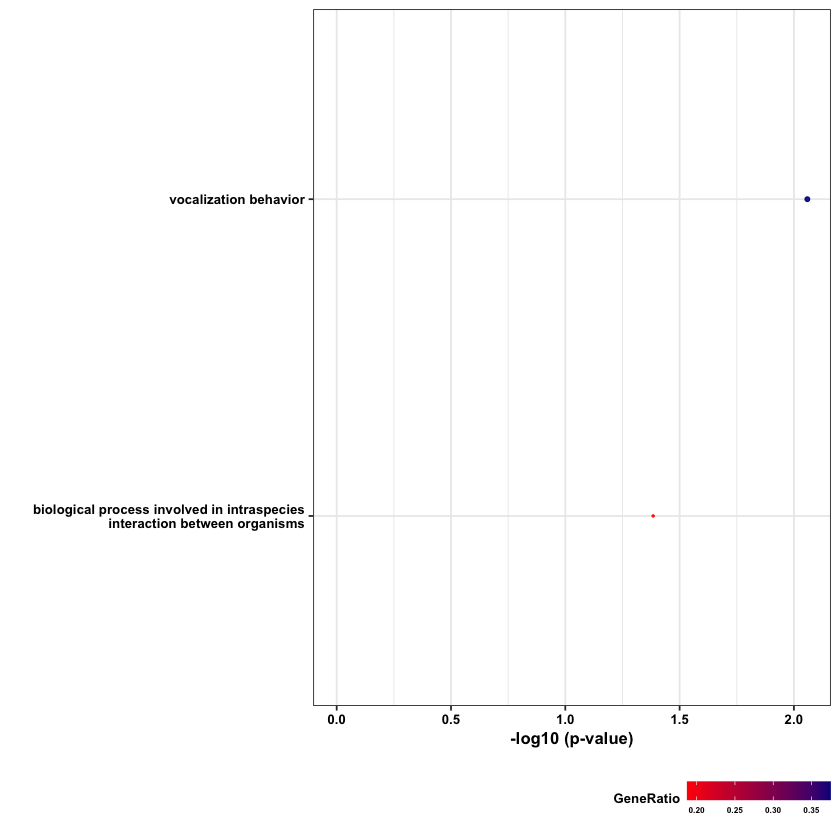

In [309]:
Goterm_matrix <- NULL

for(str in c("BP")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        goterm <- REVIGO_all[[1]][[str]][, c("TermID", "Name", "p.value", 
                                             "adj.p.value", "Annotated", "Significant")]
        goterm$category <- rep(str, nrow(goterm))
        Goterm_matrix <- rbind(Goterm_matrix, goterm)
    }
}
#print(Goterm_matrix)

Goterm_matrix$description <- sapply(Goterm_matrix$Name, function(x){
    if (nchar(x) <= 50)
        return(x)
    else{
        idx <- 50
        while(TRUE){
            if(str_sub(x, idx, idx) == " ")
                break
            else
                idx <- idx - 1
        }
    }
        return(paste(str_sub(x, 1, idx - 1), "\n", str_sub(x, idx + 1), sep = ""))
})
Goterm_matrix$description <- factor(Goterm_matrix$description, levels = rev(Goterm_matrix$description))
Goterm_matrix$ratio <- Goterm_matrix$Significant / Goterm_matrix$Annotated

max_ratio <- max(Goterm_matrix$ratio)
min_ratio <- min(Goterm_matrix$ratio)
#print(max_ratio)
#print(min_ratio)
xmax <- max(-log10(Goterm_matrix$adj.p.value))
#print(xmax)
#print(nrow(Goterm_matrix))

max_nodesize <- max(subset(Goterm_matrix, category == "BP")$Annotated)/50
p_BP <- ggplot(data=subset(Goterm_matrix, category == "BP"), aes(x=-log10(adj.p.value), y=description)) +
    geom_point(aes(color = ratio, size = Annotated), alpha = 0.9) +
    scale_size(range = c(1, max_nodesize), breaks = seq(0, 200, 50), name="Annotation") + 
    scale_colour_gradient(limits = c(min_ratio, max_ratio), low = "red", high = "darkblue", name="GeneRatio") +
    guides(size = guide_legend(order=1), 
           color = guide_colourbar(order=2)) +
    xlab("-log10 (p-value)") + ylab("") + xlim(0, xmax) +
    #facet_wrap(~category,  ncol=1, strip.position = "right", scales = "free_y") +
    theme_bw() +
    theme(legend.position = "bottom",
          #plot.margin = unit(c(0, 0, 0, 0), "cm"),
          legend.text = element_text(size = 5, color = "black", face = "bold"),
          legend.title = element_text(size = 8, color = "black", face = "bold"),
          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                         vjust = 1, hjust = 0.5),
              axis.title.x = element_text(size = 10, color = "black", face = "bold"),
          axis.title.y = element_text(size = 10, color = "black", face = "bold"),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
          strip.background = element_rect(colour = "black", fill = "red2")
          )


legend <- get_legend(p_BP + theme(legend.direction = "horizontal",
                                  legend.justification = "right",
                                  legend.box.just = "center",
                                  legend.key.height = unit(0.4, "cm")))

p_BP <- p_BP + theme(legend.position='none')
p_BP <- plot_grid(p_BP, legend, align = "v", axis = "r", rel_heights = c(0.9, 0.1), nrow = 2)

#pdf("GO_term/AD_unique_genes_BP_ex.pdf", height = 6, width = 6)
print(p_BP)
#dev.off()

In [65]:
protein_in_cluster <- c(unlist(str_split(REVIGO_all[[1]]$BP$proteins, ', ')))

protein_in_cluster <- unique(protein_in_cluster)

present_matrix <- NULL

for(str in c("BP")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        present_matrix <- rbind(present_matrix, t(sapply(str_split(REVIGO_all[[1]][[str]]$proteins, ', '), 
        function(x){
            return(as.numeric(protein_in_cluster %in% x))
        })))
    }
}

colnames(present_matrix) <- protein_in_cluster

rowname <- NULL
for(str in c("BP")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        rowname <- c(rowname, paste(REVIGO_all[[1]][[str]]$Name, 
                                    REVIGO_all[[1]][[str]]$Annotated))
    }
}
#print(rowname)
#print(present_matrix)
rownames(present_matrix) <- rowname

present_matrix

#ont = data.frame(Ontology = c(rep('BP', nrow(REVIGO_all[[1]]$BP))))

#rownames(ont) = rownames(present_matrix) # name matching

pheatmap(present_matrix, filename = "GO_term/AD_unique_genes_BP_heatmap_ex.pdf",
         width = 8, height = 8,
         show_rownames=F, cluster_cols=T, cluster_rows=F, show_colnames = T,
         #annotation_row = rowname,
         angle_col = 90,
         clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         treeheight_row = 0,
         treeheight_col = 0,
         clustering_method="ward.D")

,CNTNAP2,DLG4,NRXN3,CTSB,HERC4,SBF1,WDR48,PIGQ,DCLK1,NRG3,CACNA1B,KCNQ3,KCNQ5,SLC30A3,DLGAP1
vocalization behavior 8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
biological process involved in intraspecies interaction between organisms 16,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
multicellular organismal reproductive process 78,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0
phosphatidylinositol biosynthetic process 15,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
forebrain development 55,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
behavior 112,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0
cognition 65,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
cation transmembrane transport 168,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0
regulation of ion transmembrane transport 115,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
chemical synaptic transmission 179,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1


In [310]:
protein_in_cluster <- c(unlist(str_split(REVIGO_all[[1]]$BP$proteins, ', ')), 
                        unlist(str_split(REVIGO_all[[1]]$CC$proteins, ', ')),
                        unlist(str_split(REVIGO_all[[1]]$MF$proteins, ', ')))

protein_in_cluster <- unique(protein_in_cluster)

present_matrix <- NULL

for(str in c("BP", "CC", "MF")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        present_matrix <- rbind(present_matrix, t(sapply(str_split(REVIGO_all[[1]][[str]]$proteins, ', '), 
        function(x){
            return(as.numeric(protein_in_cluster %in% x))
        })))
    }
}

colnames(present_matrix) <- protein_in_cluster

rowname <- NULL
for(str in c("BP", "CC", "MF")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        rowname <- c(rowname, paste(REVIGO_all[[1]][[str]]$Name, 
                                    REVIGO_all[[1]][[str]]$Annotated))
    }
}
#print(rowname)
#print(present_matrix)
rownames(present_matrix) <- rowname

ont = data.frame(Ontology = c(rep('BP', nrow(REVIGO_all[[1]]$BP)),
                         rep('CC', nrow(REVIGO_all[[1]]$CC)),
                         rep('MF', nrow(REVIGO_all[[1]]$MF))))

rownames(ont) = rownames(present_matrix) # name matching

pheatmap(present_matrix, filename = "GO_term/AD_unique_genes_BPCCMF_heatmap_withoutrowname_groupADND.pdf", 
         width = 8, height = 8,
         show_rownames=F, cluster_cols=T, cluster_rows=F, show_colnames = T,
         annotation_row = ont,
         angle_col = 90,
         clustering_distance_rows="euclidean",
         clustering_distance_cols="euclidean",
         treeheight_row = 0,
         treeheight_col = 0,
         clustering_method="ward.D")

,TermID,Name,p.value,adj.p.value,Annotated,Significant,category,description,ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
51,GO:0071625,vocalization behavior,0.000091,0.0087360,8,3,BP,vocalization behavior,0.37500000
50,GO:0051703,biological process involved in intraspecies interaction between organisms,0.000860,0.0412800,16,3,BP,biological process involved in intraspecies interaction between organisms,0.18750000
1,GO:0044304,main axon,0.001070,0.0305225,35,4,CC,main axon,0.11428571
76,GO:0005887,integral component of plasma membrane,0.002230,0.0305225,184,8,CC,integral component of plasma membrane,0.04347826
38,GO:0034702,ion channel complex,0.003380,0.0305225,78,5,CC,ion channel complex,0.06410256
8,GO:1990351,transporter complex,0.004210,0.0305225,82,5,CC,transporter complex,0.06097561
11,GO:0005085,guanyl-nucleotide exchange factor activity,0.001500,0.0465000,39,2,MF,guanyl-nucleotide exchange factor activity,0.05128205


[1] 0.375
[1] 0.04347826
[1] 2.058687
[1] 7


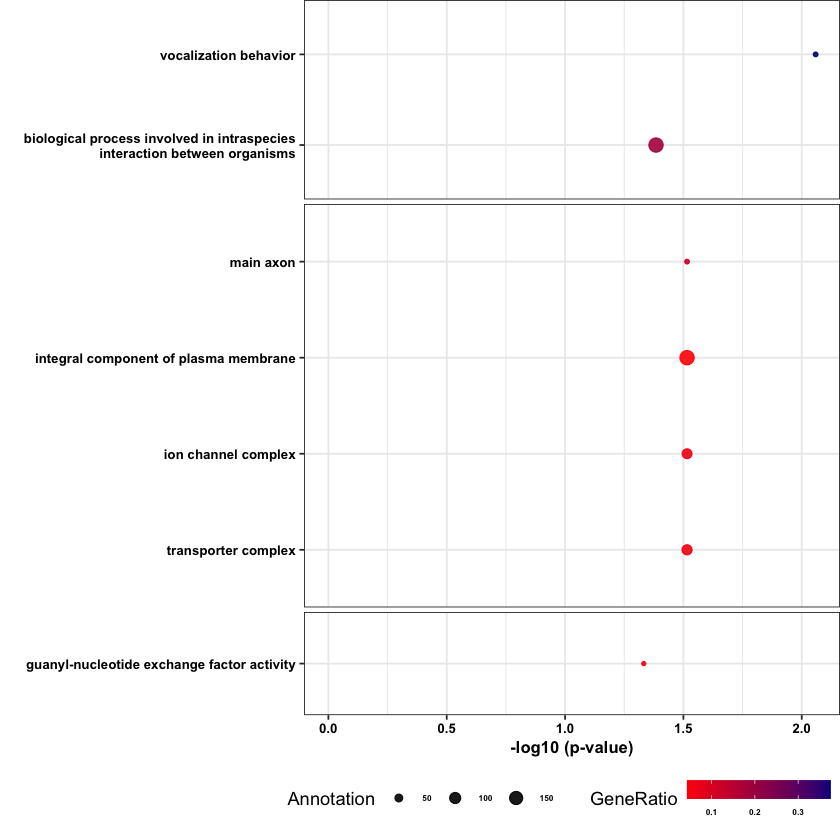

In [314]:
Goterm_matrix <- NULL

for(str in c("BP", "CC", "MF")){
    if(nrow(REVIGO_all[[1]][[str]]) != 0){
        goterm <- REVIGO_all[[1]][[str]][, c("TermID", "Name", "p.value", 
                                             "adj.p.value", "Annotated", "Significant")]
        goterm$category <- rep(str, nrow(goterm))
        Goterm_matrix <- rbind(Goterm_matrix, goterm)
    }
}
Goterm_matrix$description <- sapply(Goterm_matrix$Name, function(x){
    if (nchar(x) <= 50)
        return(x)
    else{
        idx <- 50
        while(TRUE){
            if(str_sub(x, idx, idx) == " ")
                break
            else
                idx <- idx - 1
        }
    }
        return(paste(str_sub(x, 1, idx - 1), "\n", str_sub(x, idx + 1), sep = ""))
})
Goterm_matrix$description <- factor(Goterm_matrix$description, levels = rev(Goterm_matrix$description))
Goterm_matrix$ratio <- Goterm_matrix$Significant / Goterm_matrix$Annotated

Goterm_matrix

max_ratio <- max(Goterm_matrix$ratio)
min_ratio <- min(Goterm_matrix$ratio)
print(max_ratio)
print(min_ratio)
xmax <- max(-log10(Goterm_matrix$adj.p.value))
print(xmax)

print(nrow(Goterm_matrix))

max_nodesize <- max(Goterm_matrix$Annotated)/50
p_BP <- ggplot(data=subset(Goterm_matrix, category == "BP"), aes(x=-log10(adj.p.value), y=description)) +
    geom_point(aes(color = ratio, size = Annotated), alpha = 0.9) +
    scale_size(range = c(1, max_nodesize), breaks = seq(0, 200, 50), name="Annotation") + 
    scale_colour_gradient(limits = c(min_ratio, max_ratio), low = "red", high = "darkblue", name="GeneRatio") +
    guides(size = guide_legend(order=1), 
           color = guide_colourbar(order=2)) +
    xlab("") + ylab("") + xlim(0, xmax) +
    #facet_wrap(~category,  ncol=1, strip.position = "right", scales = "free_y") +
    theme_bw() +
    theme(legend.position = "none",
          plot.margin = unit(c(0, 0, 0, 0), "cm"),
          legend.text = element_text(size = 5, color = "black", face = "bold"),
          legend.title = element_text(size = 8, color = "black", face = "bold"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 10, color = "black", face = "bold"),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
          strip.background = element_rect(colour = "black", fill = "red2")
          )

max_nodesize <- max(Goterm_matrix$Annotated)/50
p_CC <- ggplot(data=subset(Goterm_matrix, category == "CC"), aes(x=-log10(adj.p.value), y=description)) +
    geom_point(aes(color = ratio, size = Annotated), alpha = 0.9) +
    scale_size(range = c(1, max_nodesize), breaks = seq(0, 200, 50), name="Annotation") + 
    scale_colour_gradient(limits = c(min_ratio, max_ratio), low = "red", high = "darkblue", name="GeneRatio") +
    guides(size = guide_legend(order=1), 
           color = guide_colourbar(order=2)) +
    xlab("") + ylab("") + xlim(0, xmax) +
    #facet_wrap(~category,  ncol=1, strip.position = "right", scales = "free_y") +
    theme_bw() +
    theme(legend.position = "bottom",
          plot.margin = unit(c(0, 0, 0, 0), "cm"),
          legend.text = element_text(size = 5, color = "black", face = "bold"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x=element_blank(),
          axis.title.y = element_text(size = 10, color = "black", face = "bold"),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
          strip.background = element_rect(colour = "black", fill = "orange")
          )

max_nodesize <- max(subset(Goterm_matrix, category == "MF")$Annotated)/50
p_MF <- ggplot(data=subset(Goterm_matrix, category == "MF"), aes(x=-log10(adj.p.value), y=description)) +
    geom_point(aes(color = ratio, size = Annotated), alpha = 0.9) +
    scale_size(range = c(1, max_nodesize), breaks = seq(0, 200, 50), name="Annotation") + 
    scale_colour_gradient(limits = c(min_ratio, max_ratio), low = "red", high = "darkblue") +
    xlab("-log10 (p-value)") + ylab("") + xlim(0, xmax) +
    #facet_wrap(~category,  ncol=1, strip.position = "right", scales = "free_y") +
    theme_bw() +
    theme(legend.position = "none",
          plot.margin = unit(c(0, 0, 0, 0), "cm"),
          legend.text = element_text(size = 5, color = "black", face = "bold"),
          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                     vjust = 1, hjust = 0.5),
          axis.title.x = element_text(size = 10, color = "black", face = "bold"),
          axis.title.y = element_text(size = 10, color = "black", face = "bold"),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
          strip.background = element_rect(colour = "black", fill = "green3")
          )
height <- (table(Goterm_matrix$category) * c(0.85, 0.85, 1.2))/nrow(Goterm_matrix)

legend <- get_legend(p_CC + theme(legend.direction = "horizontal",
                                  legend.justification = "right",
                                  legend.box.just = "center",
                                  legend.key.height = unit(0.4, "cm")))
p_CC <- p_CC + theme(legend.position='none')
p <- plot_grid(p_BP, p_CC, p_MF, align = "v", axis = "lr", rel_heights = height, nrow = 3)
p <- plot_grid(p, legend, align = "v", axis = "r", rel_heights = c(0.9, 0.1), nrow = 2)

print(p)
save_plot("GO_term/AD_unique_genes_BPCCMF_groupADND.pdf", 
          p, nrow = 3, base_height = 2, base_width = 6)

### This is for mutations that present in multiple samples, differentially presented in AD and NCI

In [45]:
res_all <- mutated_gene_sample[c("ID", "REF", "ALT", "EFFECT", "GENE")]

In [46]:
res_all$ADND_p_value <- sapply(1:nrow(mutated_gene_sample), function(x){
    if(sum(mutated_gene_sample[x, ][sample_info_for_Ex$individualID] == 1) == 
       length(mutated_gene_sample[x, ][sample_info_for_Ex$individualID])){
       return(1)
    }
    
    return(fisher.test(x = as.factor(mutated_gene_sample[x, ][sample_info_for_Ex$individualID]), 
                       y = as.factor(sample_info_for_Ex$ADND), alternative = "less")$p.value)
})

In [47]:
res_all$ADNAD_p_value <- sapply(1:nrow(mutated_gene_sample), function(x){
    if(sum(mutated_gene_sample[x, ][subset(sample_info_for_Ex, group != "Other")$individualID] == 1) == 
       length(mutated_gene_sample[x, ][subset(sample_info_for_Ex, group != "Other")$individualID])){
       return(1)
    }
    if(sum(mutated_gene_sample[x, ][subset(sample_info_for_Ex, group != "Other")$individualID] == 0) == 
       length(mutated_gene_sample[x, ][subset(sample_info_for_Ex, group != "Other")$individualID])){
       return(1)
    }
    
    return(fisher.test(x = as.factor(mutated_gene_sample[x, ][subset(sample_info_for_Ex, group != "Other")$individualID]), 
                       y = as.factor(subset(sample_info_for_Ex, group != "Other")$group), 
                       alternative = "less")$p.value)
})

In [48]:
res_all[res_all$ADNAD_p_value < 0.05,]

,ID,REF,ALT,EFFECT,GENE,ADND_p_value,ADNAD_p_value
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
47708,6:73374221,G,GA,intron_variant,KCNQ5,0.02437999,0.01375112
88449,13:36667102,C,CA,intron_variant,DCLK1,0.02605812,0.02303103


In [50]:
for(i in 1:2){
    print(table(as.factor(mutated_gene_sample[which(res_all$ADNAD_p_value < 0.05)[i], ][sample_info_for_Ex$individualID]), 
      as.factor(sample_info_for_Ex$group)))
    
}

   
    AD ND Other
  0 28 42     0
  1  5  0     1
   
    AD ND Other
  0 23 38     1
  1 10  4     0


### This is the test for age, the age-related mutation occurrence 

In [73]:
res_all$age_p_value <- sapply(1:nrow(mutated_gene_sample), function(x){
    for_one_sample <- data.frame(count = as.factor(t(mutated_gene_sample[x,][c(sample_info_for_Ex$individualID)])), 
                                 age = sample_info_for_Ex$age,
                                 sex = sample_info_for_Ex$sex,
                                 group = sample_info_for_Ex$group, 
                                 study = sample_info_for_Ex$study) 
    #print(for_one_sample)
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial)))
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial))$coefficients[2, 4])
    
    return(summary(glm(count~age + group, data = subset(for_one_sample, group != "Other"), #subset(for_one_sample, group != "Other"),
                       family = binomial))$coefficients[2, 4])
})

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted 

In [74]:
res_all$age_effect_size <- sapply(1:nrow(mutated_gene_sample), function(x){
    for_one_sample <- data.frame(count = as.factor(t(mutated_gene_sample[x,][c(sample_info_for_Ex$individualID)])), 
                                 age = sample_info_for_Ex$age,
                                 sex = sample_info_for_Ex$sex,
                                 group = sample_info_for_Ex$group, 
                                 study = sample_info_for_Ex$study) 
    #print(for_one_sample)
    
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial)))
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial))$coefficients[2, 4])
    
    return(summary(glm(count~age + group, data = subset(for_one_sample, group != "Other"), #subset(for_one_sample, group != "Other"),
                       family = binomial))$coefficients[2, 1])
})

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted 

In [77]:
res_all$ageS90_p_value <- sapply(1:nrow(mutated_gene_sample), function(x){
    for_one_sample <- data.frame(count = as.factor(t(mutated_gene_sample[x,][c(sample_info_for_Ex$individualID)])), 
                                 age = sample_info_for_Ex$age,
                                 sex = sample_info_for_Ex$sex,
                                 group = sample_info_for_Ex$group, 
                                 study = sample_info_for_Ex$study) 
    #print(for_one_sample)
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial)))
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial))$coefficients[2, 4])
    
    return(summary(glm(count~age + group, data = subset(for_one_sample, (group != "Other") & (age<90)), #subset(for_one_sample, group != "Other"),
                       family = binomial))$coefficients[2, 4])
})

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fi

In [78]:
res_all$ageS90_effect_size <- sapply(1:nrow(mutated_gene_sample), function(x){
    for_one_sample <- data.frame(count = as.factor(t(mutated_gene_sample[x,][c(sample_info_for_Ex$individualID)])), 
                                 age = sample_info_for_Ex$age,
                                 sex = sample_info_for_Ex$sex,
                                 group = sample_info_for_Ex$group, 
                                 study = sample_info_for_Ex$study) 
    #print(for_one_sample)
    
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial)))
    #print(summary(glm(count~age + sex + cogdx, data = for_one_sample, family = binomial))$coefficients[2, 4])
    
    return(summary(glm(count~age + group, data = subset(for_one_sample, (group != "Other") & (age<90)), #subset(for_one_sample, group != "Other"),
                       family = binomial))$coefficients[2, 1])
})

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fi

In [79]:
subset(res_all, (age_p_value < 0.05) & (age_effect_size > 0))

,ID,REF,ALT,EFFECT,GENE,ADND_p_value,ADNAD_p_value,age_p_value,age_effect_size,ageS90_p_value,ageS90_effect_size
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33027,4:21788463,C,T,intron_variant,KCNIP4,0.9524356,0.8652120,0.04471031,0.1394832,0.03369165,0.2108560
101133,16:6899517,A,G,intron_variant,RBFOX1,0.9699468,0.8724607,0.04360329,0.1261292,0.01967726,0.2318222



	Fisher's Exact Test for Count Data

data:  as.factor(subset(for_one_sample, group != "Other")$count) and as.factor(subset(for_one_sample, group != "Other")$group)
p-value = 0.5622
alternative hypothesis: two.side



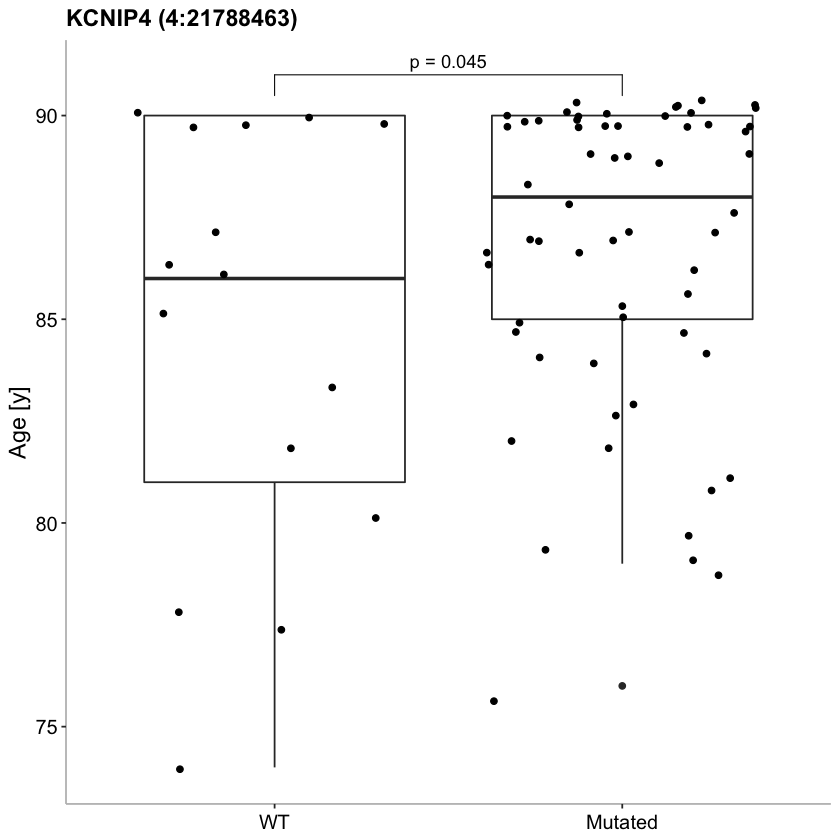

In [111]:
idx <- which(mutated_gene_sample$ID == "4:21788463")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 

print(fisher.test(x = as.factor(subset(for_one_sample, group != "Other")$count),
                  y = as.factor(subset(for_one_sample, group != "Other")$group), 
                  alternative = "two.side"))

plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.045")

plot_table$y.position <- 91

p_age_1 <- ggplot(subset(for_one_sample, group != "Other"), aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter() +
    ylab("Age [y]") + 
    ggtitle("KCNIP4 (4:21788463)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_1


	Fisher's Exact Test for Count Data

data:  as.factor(subset(for_one_sample, group != "Other")$count) and as.factor(subset(for_one_sample, group != "Other")$group)
p-value = 0.4811
alternative hypothesis: two.side



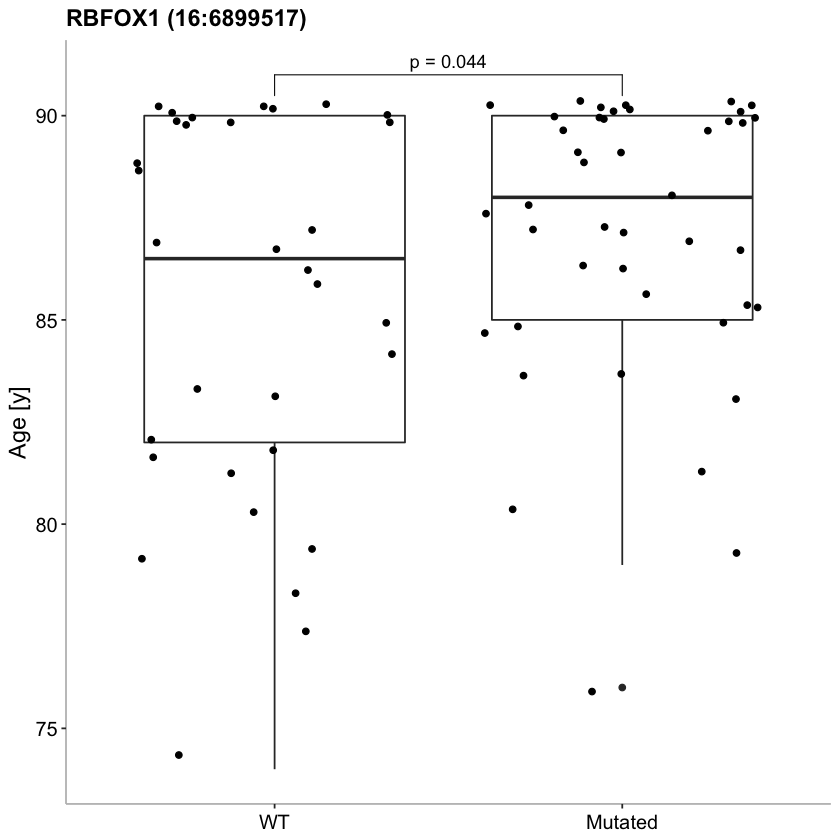

In [112]:
idx <- which(mutated_gene_sample$ID == "16:6899517")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 

print(fisher.test(x = as.factor(subset(for_one_sample, group != "Other")$count),
                  y = as.factor(subset(for_one_sample, group != "Other")$group), 
                  alternative = "two.side"))

plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.044")

plot_table$y.position <- 91

p_age_2 <- ggplot(subset(for_one_sample, group != "Other"), aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter() +
    ylab("Age [y]") + 
    ggtitle("RBFOX1 (16:6899517)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size + font_size_add, color = "black"),
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_2

In [96]:
age_plot <- plot_grid(p_age_2, p_age_1, 
          align = "hv", axis = "lr", 
          labels = c("A", "B"), label_size = 16, hjust = 0, vjust = 1.3,
          nrow = 1, ncol = 2)

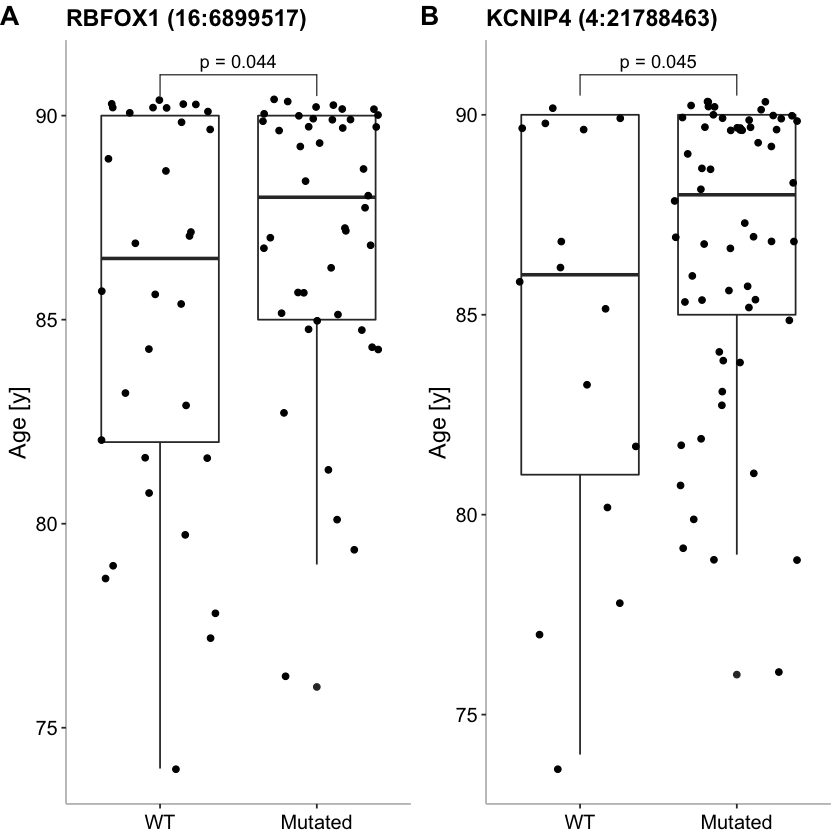

In [97]:
age_plot

In [98]:
save_plot("Plot_out/Somatic_GENEs_age_plot_adapted-20221212.pdf", age_plot, ncol = 2, base_height = 6, base_width = 5)

In [124]:
color_AD <- "#FF3300"
color_ND <- "blue"

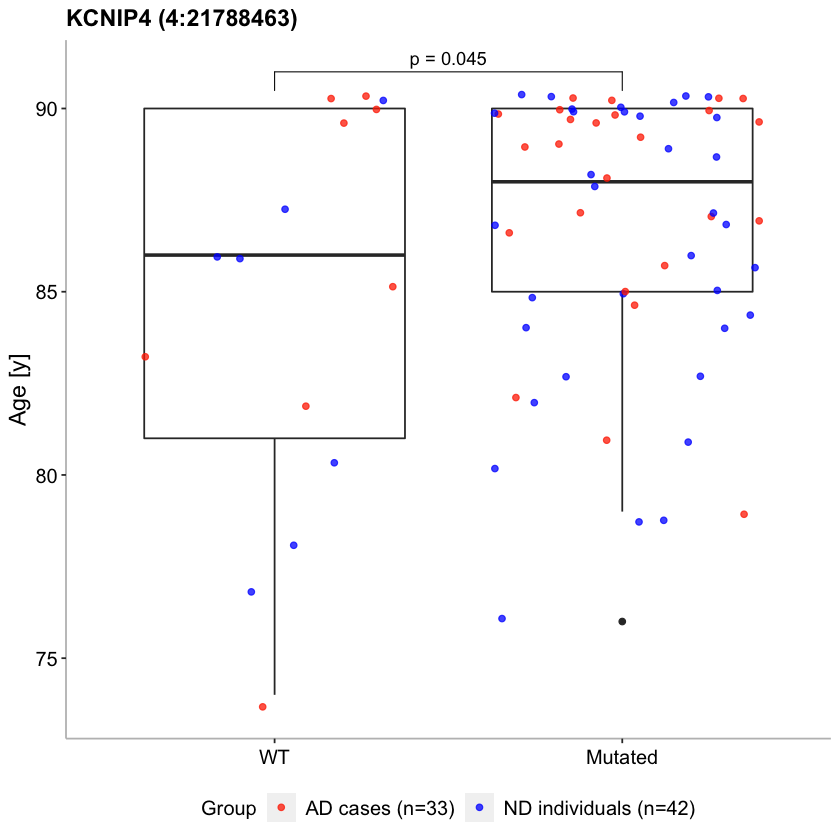

In [153]:
idx <- which(mutated_gene_sample$ID == "4:21788463")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 


plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.045")

plot_table$y.position <- 91

p_age_1 <- ggplot(subset(for_one_sample, group != "Other"), aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter(aes(color = group, fill = group), shape = 21, alpha = 0.75) +
    ylab("Age [y]") + 
    ggtitle("KCNIP4 (4:21788463)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    scale_color_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 
    scale_fill_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size, color = "black"),
          legend.title = element_text(size = font_size, color = "black"),
          
          legend.position = "bottom",
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_1

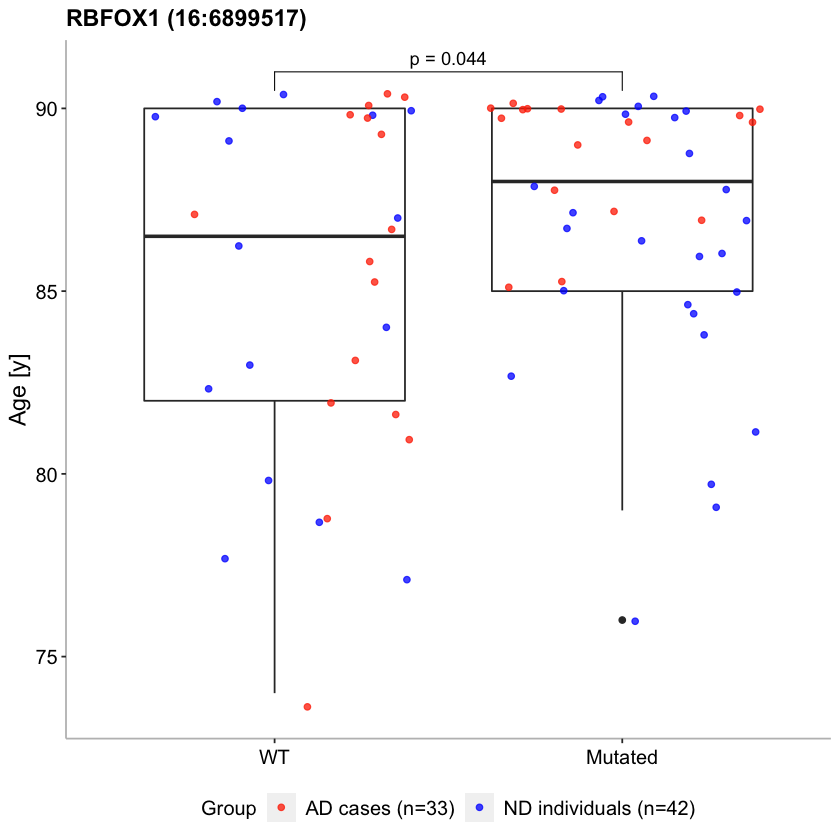

In [154]:
idx <- which(mutated_gene_sample$ID == "16:6899517")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 

plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.044")

plot_table$y.position <- 91

p_age_2 <- ggplot(subset(for_one_sample, group != "Other"), aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter(aes(color = group, fill = group), shape = 21, alpha = 0.75) +
    ylab("Age [y]") + 
    ggtitle("RBFOX1 (16:6899517)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    scale_color_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 
    scale_fill_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size, color = "black"),
          legend.title = element_text(size = font_size, color = "black"),
          legend.position = "bottom",
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_2

In [155]:
age_plot <- plot_grid(p_age_2 + theme(legend.position = "none"), p_age_1 + theme(legend.position = "none"), 
          align = "hv", axis = "lr", 
          labels = c("A", "B"), label_size = 16, hjust = 0, vjust = 1.3,
          nrow = 1, ncol = 2)

In [156]:
age_plot_legend <- plot_grid(age_plot, get_legend(p_age_2), nrow = 2,
                             align = "hv", axis = "lr", rel_heights = c(0.95, 0.05))

In [157]:
save_plot("Plot_out/Somatic_GENEs_age_plot_colored-20221212.pdf", age_plot_legend, ncol = 2, base_height = 6, base_width = 5)

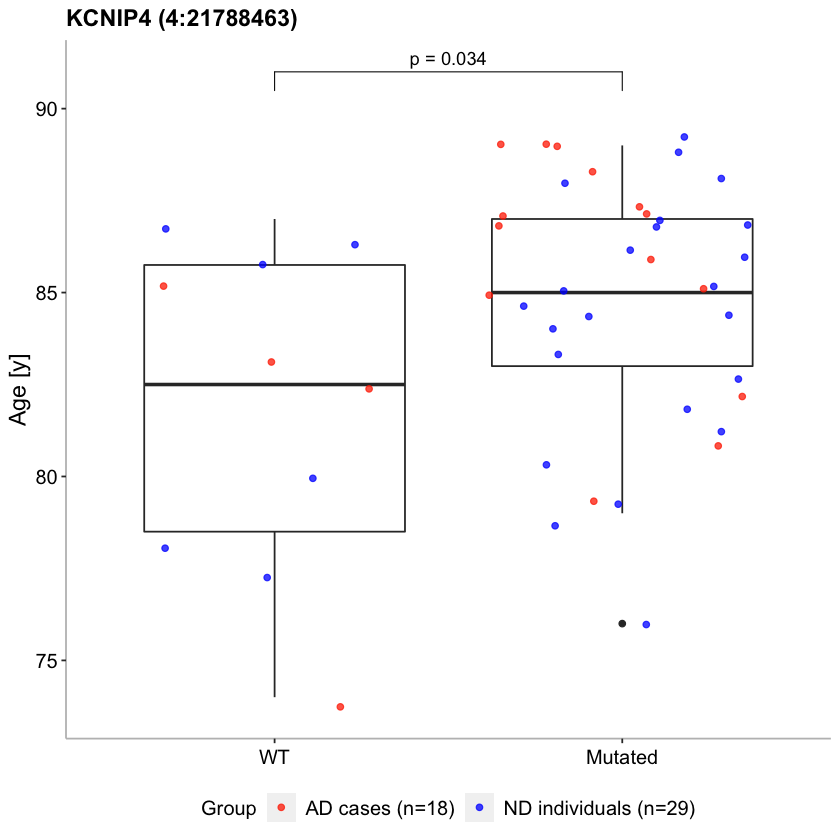

In [166]:
idx <- which(mutated_gene_sample$ID == "4:21788463")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 

plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.034")

plot_table$y.position <- 91

for_one_sample <- subset(for_one_sample, (group != "Other") & (age<90))

p_age_1 <- ggplot(for_one_sample, aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter(aes(color = group, fill = group), shape = 21, alpha = 0.75) +
    ylab("Age [y]") + 
    ggtitle("KCNIP4 (4:21788463)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    scale_color_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    scale_fill_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size, color = "black"),
          legend.title = element_text(size = font_size, color = "black"),
          legend.position = "bottom",
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_1

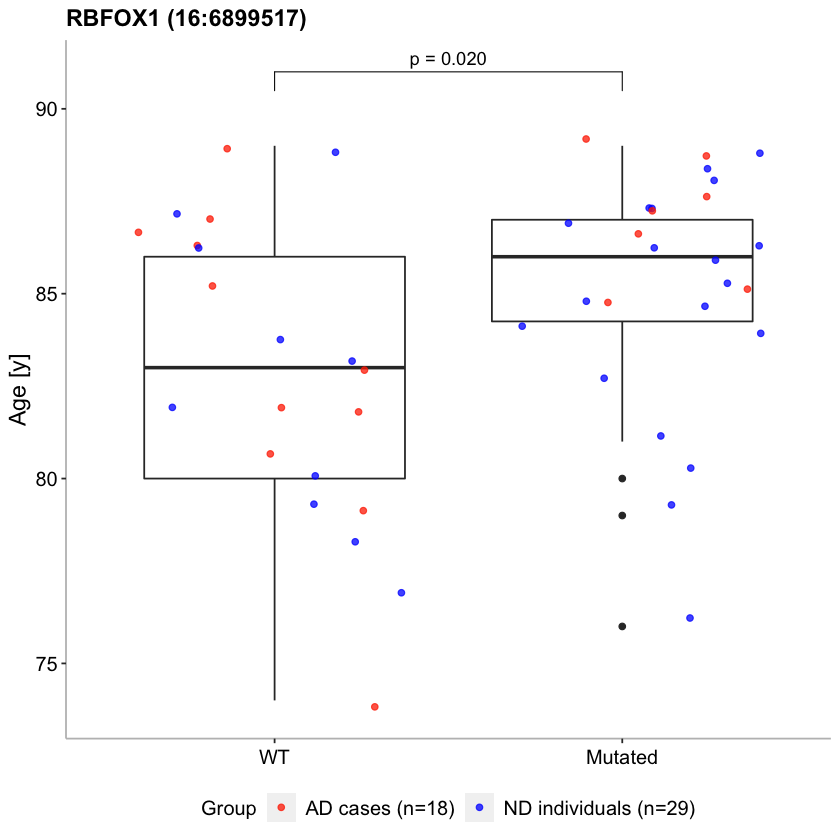

In [167]:
idx <- which(mutated_gene_sample$ID == "16:6899517")

for_one_sample <- data.frame(count = as.numeric(t(mutated_gene_sample[idx,][c(sample_info_for_Ex$individualID)])), 
                             age = sample_info_for_Ex$age,
                             group = sample_info_for_Ex$group) 

plot_table <- data.frame(`.y.` = "age",
                     group1 = "0", 
                     group2 = "1",
                     test_label = "p = 0.020")

plot_table$y.position <- 91

for_one_sample <- subset(for_one_sample, (group != "Other") & (age<90))

p_age_2 <- ggplot(for_one_sample, aes(x=as.factor(count), y=age)) +
    geom_boxplot() + 
    geom_jitter(aes(color = group, fill = group), shape = 21, alpha = 0.75) +
    ylab("Age [y]") + 
    ggtitle("RBFOX1 (16:6899517)") +
    scale_x_discrete(breaks=c("0", "1"), 
                     labels = c("WT", "Mutated")) + 

    scale_color_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    scale_fill_manual(name="Group", breaks = c("AD", "ND"), 
                       values = c(color_AD, color_ND),
                       labels = c(paste("AD cases (n=", length(which(for_one_sample$group == "AD")), ")", sep = ''),
                                  paste("ND individuals (n=", length(which(for_one_sample$group == "ND")), ")", sep = '')
                                 )
                      ) + 

    stat_pvalue_manual(plot_table, label = "test_label") +
    
    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),

          plot.title = element_text(face = "bold", colour = "black", size = font_size+font_size_add#, 
                                    #hjust = -0.4
                                   ),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "grey"),
          
          legend.text = element_text(size = font_size, color = "black"),
          legend.title = element_text(size = font_size, color = "black"),
          legend.position = "bottom",
          
          axis.title.x = element_blank(), #element_text(color = "black", size = font_size+font_size_add),
          axis.title.y = element_text(color = "black", size = font_size+font_size_add),
          
          axis.text.x = element_text(size = font_size, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black")
         )
p_age_2

In [168]:
age_plot <- plot_grid(p_age_2 + theme(legend.position = "none"), p_age_1 + theme(legend.position = "none"), 
          align = "hv", axis = "lr", 
          labels = c("A", "B"), label_size = 16, hjust = 0, vjust = 1.3,
          nrow = 1, ncol = 2)

In [169]:
age_plot_legend <- plot_grid(age_plot, get_legend(p_age_2), nrow = 2,
                             align = "hv", axis = "lr", rel_heights = c(0.95, 0.05))

In [170]:
save_plot("Plot_out/Somatic_GENEs_age_plot_colored_remove90-20221212.pdf", age_plot_legend, ncol = 2, base_height = 6, base_width = 5)